# XGBoost: A Scalable Tree Boosting System

## Introduction
Tree boosting is a powerful machine learning technique that achieves state-of-the-art performance across various applications, such as classification, ranking, and regression. The XGBoost paper presents a highly scalable and efficient implementation of gradient tree boosting, making it a preferred choice among data scientists for machine learning competitions and real-world applications. 

XGBoost introduces several novel contributions:
- **Sparsity-aware learning**: Optimized handling of sparse data
- **Weighted quantile sketch**: A new method for efficiently handling weighted datasets
- **Scalability**: Effective use of cache-aware algorithms, parallelism, and out-of-core computation

These innovations make XGBoost a go-to solution for both small-scale and large-scale datasets.

### Key Techniques

#### 1. Regularized Learning Objective
XGBoost enhances gradient boosting by introducing a regularized learning objective. The model minimizes the following loss:

$$
L(\phi) = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k),
$$

where:
- $ l(y_i, \hat{y}_i) $ is a differentiable convex loss function, such as mean squared error or logistic loss.
- $ \Omega(f_k) = \gamma T + \frac{\lambda}{2} \|w\|^2 $ penalizes model complexity with:
  - $ T $: Number of leaves in the tree
  - $ w $: Leaf weights
  - $ \gamma, \lambda $: Regularization parameters

#### 2. Split-Finding Algorithms
- **Exact Greedy Algorithm**: Evaluates all possible splits to find the optimal one, ensuring high accuracy
- **Approximate Algorithm**: Proposes candidate splits using quantiles, enabling efficient computation for large datasets

#### 3. Parallel and Distributed Learning
XGBoost supports parallel computation for split finding and distributed training across clusters, achieving significant speedups. 

#### 4. Cache-Aware and Out-of-Core Computation
- **Cache-Aware Learning**: Optimizes memory access patterns to reduce computation time.
- **Out-of-Core Learning**: Handles datasets that exceed memory capacity by efficiently utilizing disk storage through techniques like block compression and sharding.


### Applications
XGBoost has demonstrated exceptional performance in various domains:
- **Competitions**: Used in 17 out of 29 winning solutions on Kaggle in 2015, including applications in ad click-through rate prediction, web ranking, and store sales forecasting.
- **Physics**: High-energy physics event classification.
- **Finance**: Fraud detection and customer behavior prediction.
- **Healthcare**: Risk assessment and disease prediction.

### Conclusion
XGBoost remains a state-of-the-art solution for gradient boosting due to its:
- Scalability across different data sizes and computational environments.
- Innovations in handling sparse and weighted data.
- Practical use in real-world applications and competitions.

Its combination of speed, flexibility, and predictive accuracy makes XGBoost an indispensable tool in the machine learning ecosystem.

## XGBoost Code Implementation

### Introduction
This notebook demonstrates key concepts and experiments discussed in the XGBoost paper using a public dataset. We will:
1. Preprocess the data.
2. Train an XGBoost model.
3. Evaluate the model performance using metrics like AUC and accuracy.
4. Visualize feature importance and analyze the impact of hyperparameters.

### Dataset
We use the Higgs boson dataset, which is widely used for classification tasks. The task is to predict whether an event corresponds to the Higgs boson.#### Step 1: Install xgboost

#### Install XGBoost
- Using `%%capture` to suppress the installation logs

In [1]:
%%capture
pip install xgboost

In [2]:
%%capture
pip install kagglehub

#### Import necessary libraries

In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.model_selection import GridSearchCV
import seaborn as sns

#### Downloading [**California Housing Prices**](https://www.kaggle.com/datasets/camnugent/california-housing-prices) dataset from kaggle

In [4]:
csv_path = kagglehub.dataset_download("camnugent/california-housing-prices")

#### Set a random seed for reproducibility

In [5]:
np.random.seed(42)

#### Load the `Breast Cancer` dataset directly from `kagglehub`

In [6]:
data = pd.read_csv(os.path.join(csv_path, "housing.csv"))

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The California Housing dataset includes features like median income, average number of rooms, and other housing attributes, along with the median house value as the target variable.

In [9]:
# Handling missing values (if any)
data.dropna(inplace=True)
data = pd.get_dummies(data, columns=["ocean_proximity"], drop_first=True)
# Separating features and target
X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")

Training features: (16346, 12)
Test features: (4087, 12)


#### Train the XGBoost Model
We configure the model with:
- Learning rate $\eta$: **0.1**
- Maximum tree depth: **6**
- Number of estimators: **100**

In [36]:
# Set up the XGBoost model
xgb_model = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    objective='reg:squarederror',
    reg_lambda=1,
    reg_alpha=0,
    gamma=1,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Evaluate the Model
We compute the following metrics:
1. Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values
2. $R^2$ Score: Indicates the proportion of variance explained by the model

In [18]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 2454400029.33
R^2 Score: 0.8205


#### Visualize Feature Importance
Feature importance helps us understand which features contribute most to the predictions

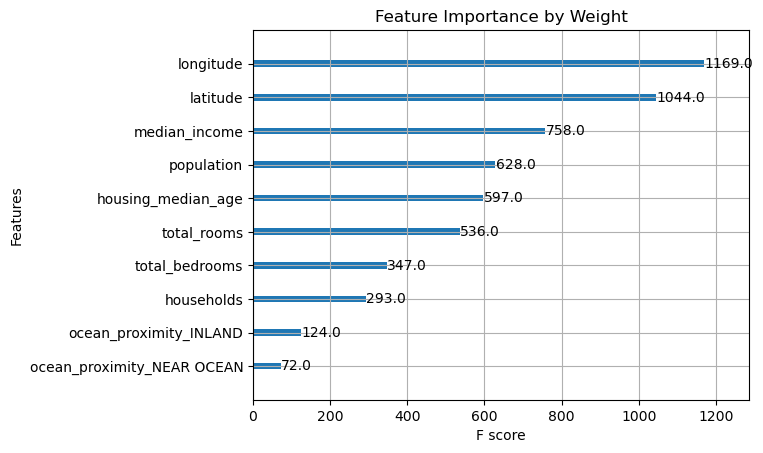

In [38]:
xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10)
plt.title("Feature Importance by Weight")
plt.show()

#### Hyperparameter Tuning
We analyze the effect of parameters like `max_depth` and `learning_rate` on model performance.

In [21]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R^2 score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 9}
Best R^2 score: 0.8236891260890083


### Visualization

#### 1. Distribution of Actual vs. Predicted Values

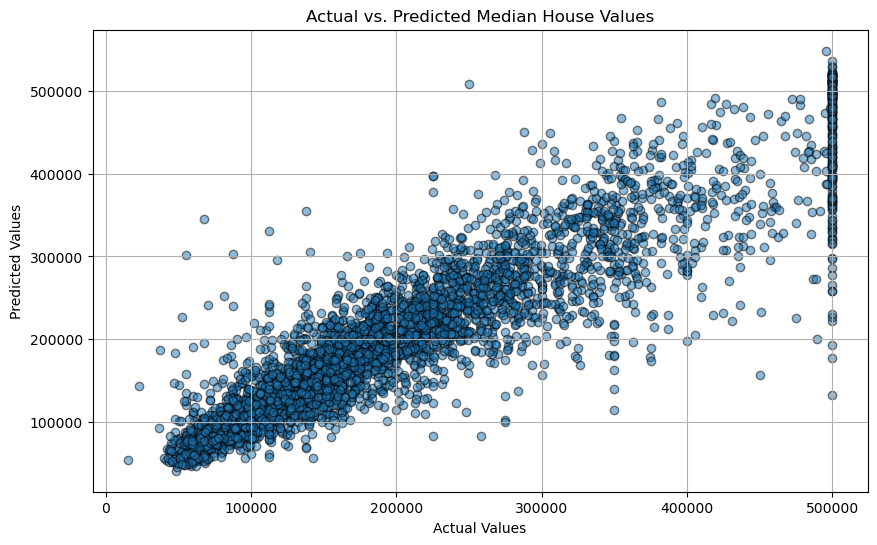

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Median House Values")
plt.grid(True)
plt.show()

#### 2. Residual Plot

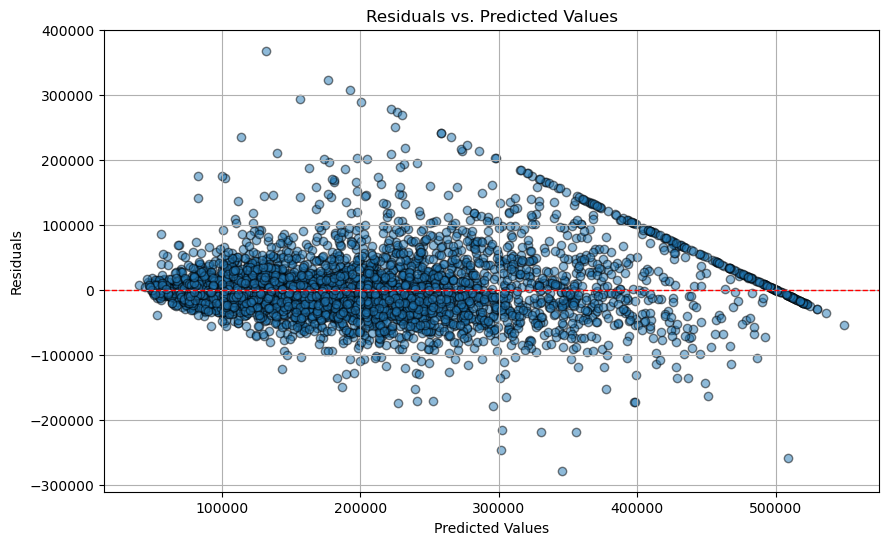

In [29]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

#### 3. Feature Correlation Heatmap

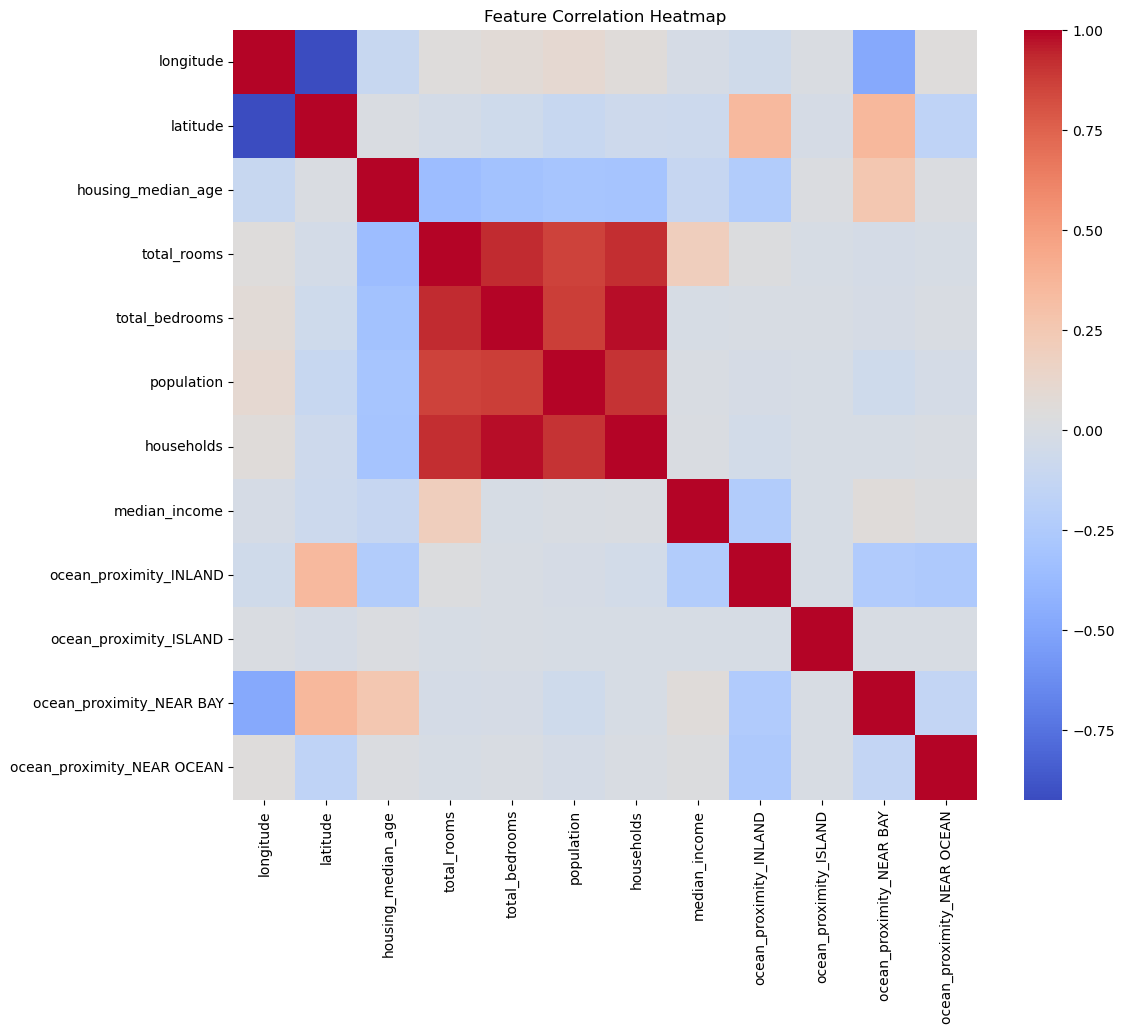

In [40]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

#### Conclusion
1. XGBoost achieves competitive performance on the California Housing dataset.
2. Feature importance analysis highlights key contributors like median income and location.
3. Hyperparameter tuning reveals how model performance depends on `max_depth` and `learning_rate`.